<div style="border: 5px solid purple; padding: 15px; margin: 5px">
<b> Reviewer's comment 3</b>
    


Thank you very much for sending a new version! My new comments have digit 3, but there are no issues that need your attention. I hope you enjoyed this project.

Your project has passed code review. Congratulations 😊

    
Good luck! 😊 
    

    
</div>

<div style="border: 5px solid purple; padding: 15px; margin: 5px">
<b> Reviewer's comment</b>
    
Hi Sabrina! Congratulations on submitting Computer Vision project! 🎉
    


It looks like you may have accidentally submitted the project for review. If it is the case, let me send it back to you so that you can complete the tasks. If you need assistance, feel free to schedule a 1:1 sessions with our tutors or TAs [here](https://calendly.com/tripleten-ds-experts-team), join daily coworking sessions, or ask questions in the sprint channels on Discord 😉


<hr>
    
    
✍️ Here's a nice playlist [Introduction to
Deep Learning](https://www.youtube.com/playlist?list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI) on youtube that you may find helpful and interesting. This is another interesting [Computer Vision Playlist](https://www.youtube.com/playlist?list=PLf7L7Kg8_FNxHATtLwDceyh72QQL9pvpQ).     
 
    
    
Here's a link to [AI for beginners](https://github.com/microsoft/ai-for-beginners) course by Microsoft. 
    

</div>

<div style="border: 5px solid blue; padding: 15px; margin: 5px">
<b> Student's comment</b>
Thank you for the feedback. I was a little confused why there where to notebooks in this project. I completed it on the previous notebook and had to transfer it to this final notebook. Here is the completed project.

</div>

<div style="border: 5px solid purple; padding: 15px; margin: 5px">
<b> Reviewer's comment 2</b>
    


Understood :) Thank you for the updates! I've left a few comments titled as **Reviewer's comment 2**. Please take a look :) 

     
</div>

# Face Value: Leveraging AI to Prevent Underage Alcohol Purchases in Supermarkets

## Project Description

**Project description**

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:

The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
Computer vision methods can be used to determine age of a person from a photo
The task then is to build and evaluate a model for verifying people's age
To start working on the task, you'll have a set of photographs of people with their ages indicated.

**Project Instructions**

- Perform exploratory data analysis to get an overall impression of the dataset.
- Train and evaluate the model (it needs to be done on the GPU platform).
- Combine your code, output and findings (from the previous points) in the final Jupyter notebook.
- Make conclusions of the model evaluation, add them to the notebook.

## Initialization

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [3]:
# Load to dataset
df_labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
# Get a general overview of the data
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# View a sample of the data
df_labels.sample(10)

,file_name,real_age
5996,005997.jpg,16
1112,001112.jpg,30
4336,004336.jpg,16
6206,006209.jpg,24
2749,002749.jpg,28
3426,003426.jpg,38
4761,004761.jpg,22
1661,001661.jpg,41
990,000990.jpg,24
6956,006967.jpg,43


## EDA

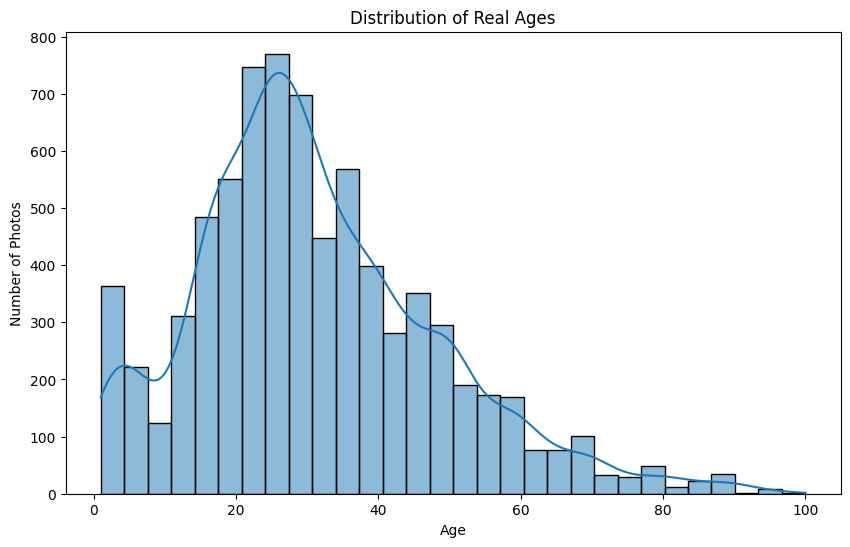

In [6]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_labels['real_age'], bins=30, kde=True)
plt.title('Distribution of Real Ages')
plt.xlabel('Age')
plt.ylabel('Number of Photos')
plt.show()

The age distribution in the dataset clearly leans toward younger individuals, with the majority of samples falling between 15 and 35 years old and peaking around age 25. As the ages increase beyond 35, the number of samples begins to taper off, and there are noticeably fewer images of individuals over 60. While there is some presence of children under 10, it's relatively limited compared to the concentration of young adults. Overall, the distribution forms a right-skewed curve, where most of the data is clustered at younger ages, and older age groups are sparsely represented.

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment 2 </b>
    
Nice chart 👍 
    
</div>
<div style="border: 5px solid gold; padding: 15px; margin: 5px">
<b>   Reviewer's comment 2 </b>
    
However, I would change `Count` to `Number of photos`, for instance.
    
</div>
<div style="border: 5px solid blue; padding: 15px; margin: 5px">
<b> Student's comment</b>
Updated.

</div>
<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment 3 </b>
    
Perfect! 

</div>

In [7]:
# Load dataset
df_images = '/datasets/faces/final_files/'

In [8]:
# Get list of image file paths (filtering only image files)
image_files = [f for f in os.listdir(df_images) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

In [9]:
# Shuffle to ensure a mix
random.shuffle(image_files)

# Select 10–15 images
sample_images = image_files[:15]

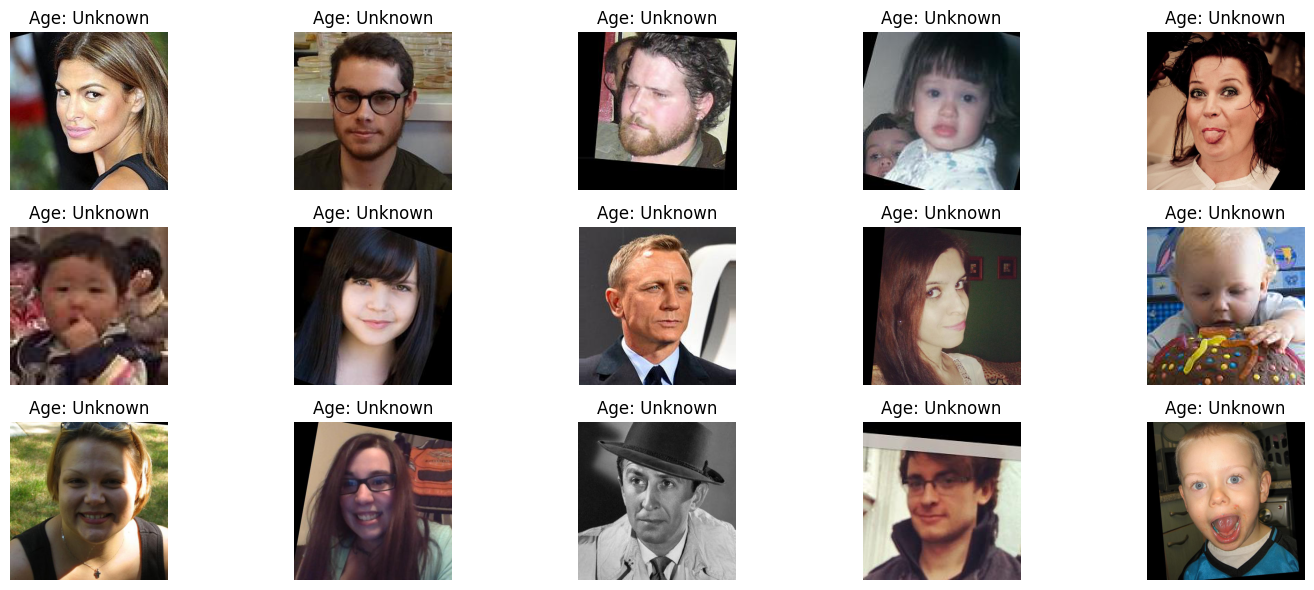

In [10]:
# Plot images
plt.figure(figsize=(15, 6))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(df_images, img_name)
    img = Image.open(img_path)
    
    # Attempt to extract age if in filename (e.g., "34_image123.jpg")
    age = img_name.split('_')[0] if '_' in img_name and img_name.split('_')[0].isdigit() else "Unknown"
    
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Findings

Since the dataset contains far fewer examples of older individuals, the model will likely struggle to accurately predict older ages. There may be bias predictions toward younger ages when the model is uncertain. It may perform inconsistently across age groups, with better accuracy for common ranges such as age 20-35 years old.

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment 2 </b>
    
Good! 

</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [10]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [17]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv(f'/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
        directory=f'/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_datagen_flow

In [18]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(f'/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=f'/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',                                                 
        seed=12345
    )

    return test_datagen_flow

<div style="border: 5px solid red; padding: 15px; margin: 5px">
<b>  Reviewer's comment 2</b>
    

Please specify the `subset` parameter. The model should know that this is the validation subset. Otherwise, the model will use the whole dataset.  
</div>
<div style="border: 5px solid blue; padding: 15px; margin: 5px">
<b> Student's comment</b>
Updated.

</div>
<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment 3 </b>
    
Now it's correct! 
</div>

In [19]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape=input_shape,
                 include_top=False,
                 weights='imagenet')
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer= Adam(learning_rate=0.0005)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment 2</b>


Correct! 
    
    
- `Dense(1, activation='relu')` is appropriate, since you are predicting a single value. Using 1 neuron makes sense here.
    
    
    
- While you could omit the activation or explicitly specify `linear`, `relu` may help because age should not be negative. 
    
    
    
- Adam optimizer with learning rate 0.0005 is a solid and commonly used choice, well done. 


- The use of MSE loss and MAE as metric is also correct. MSE encourages precision, and MAE helps us interpret error scale in the same units as the target.

</div>

In [20]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps= len(test_data)

    # Fit the model
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [21]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

#### This is the code used to train model;

```python    
train_data = load_train('/content/drive/MyDrive/faces')
test_data = load_test('/content/drive/MyDrive/faces')  

model = create_model((224, 224, 3))

train_model(model, train_data, test_data)
```

#### Place the output from the GPU platform as an Markdown cell here.

```python 
Found 7591 validated image filenames.

Found 7591 validated image filenames.

Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
  
Epoch 1/20
238/238 - 255s - 1s/step - loss: 175.4186 - mae: 9.8783 - val_loss: 357.7365 - val_mae: 13.9960
Epoch 2/20
238/238 - 116s - 487ms/step - loss: 99.3167 - mae: 7.5855 - val_loss: 405.7027 - val_mae: 15.0375
Epoch 3/20
238/238 - 107s - 448ms/step - loss: 69.0847 - mae: 6.3482 - val_loss: 170.4594 - val_mae: 10.1169
Epoch 4/20
238/238 - 144s - 605ms/step - loss: 48.0268 - mae: 5.2732 - val_loss: 50.4217 - val_mae: 5.4109
Epoch 5/20
238/238 - 109s - 459ms/step - loss: 33.4638 - mae: 4.4442 - val_loss: 46.6232 - val_mae: 5.2403
Epoch 6/20
238/238 - 108s - 452ms/step - loss: 25.5029 - mae: 3.9067 - val_loss: 45.2958 - val_mae: 5.4714
Epoch 7/20
238/238 - 108s - 454ms/step - loss: 20.1224 - mae: 3.4338 - val_loss: 15.9466 - val_mae: 3.0531
Epoch 8/20
238/238 - 107s - 450ms/step - loss: 16.9804 - mae: 3.1541 - val_loss: 36.4787 - val_mae: 4.8037
Epoch 9/20
238/238 - 108s - 453ms/step - loss: 16.6888 - mae: 3.1390 - val_loss: 24.0210 - val_mae: 3.6792
Epoch 10/20
238/238 - 142s - 597ms/step - loss: 14.6222 - mae: 2.9299 - val_loss: 11.3991 - val_mae: 2.5399
Epoch 11/20
238/238 - 107s - 448ms/step - loss: 13.5621 - mae: 2.8277 - val_loss: 15.9646 - val_mae: 3.0932
Epoch 12/20
238/238 - 145s - 609ms/step - loss: 12.7348 - mae: 2.7172 - val_loss: 13.3240 - val_mae: 2.7471
Epoch 13/20
238/238 - 108s - 452ms/step - loss: 11.3393 - mae: 2.5681 - val_loss: 15.3092 - val_mae: 3.0204
Epoch 14/20
238/238 - 106s - 446ms/step - loss: 10.9211 - mae: 2.5226 - val_loss: 15.8127 - val_mae: 3.0569
Epoch 15/20
238/238 - 142s - 598ms/step - loss: 10.1991 - mae: 2.4463 - val_loss: 12.7843 - val_mae: 2.7898
Epoch 16/20
238/238 - 143s - 602ms/step - loss: 11.4534 - mae: 2.6072 - val_loss: 38.9391 - val_mae: 5.1580
Epoch 17/20
238/238 - 142s - 598ms/step - loss: 11.8259 - mae: 2.6230 - val_loss: 18.7896 - val_mae: 3.3314
Epoch 18/20
238/238 - 108s - 453ms/step - loss: 11.6619 - mae: 2.6032 - val_loss: 15.9663 - val_mae: 3.0810
Epoch 19/20
238/238 - 108s - 455ms/step - loss: 10.5708 - mae: 2.4792 - val_loss: 19.8666 - val_mae: 3.3623
Epoch 20/20
238/238 - 141s - 593ms/step - loss: 11.0091 - mae: 2.5104 - val_loss: 23.0129 - val_mae: 3.6655
<Sequential name=sequential, built=True>
```

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b> Reviewer's comment 2</b>
   

You can use Markdown cell for your code and results: 

    ```python
    
    # code
    
    
    ```
    
Example:
    
</div>


```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

...



Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921  
```

<div style="border: 5px solid blue; padding: 15px; margin: 5px">
<b> Student's comment</b>
Updated.

</div>

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment 3 </b>
    
Looks great! 
</div>

Training results revealed that the model began with high error rates—during the first epoch, the mean absolute error (MAE) on the training set was nearly 9.88 and even higher on the validation set at 13.99. However, by epoch 5, the model showed noticeable improvements, with validation MAE dropping to 5.24. The most accurate age predictions occurred between epochs 7 and 10, where validation MAE fell below 3.0 and reached a low of around 2.54 in epoch 10. This indicates that the model was able to learn strong age-related patterns and generalize them reasonably well to unseen data.

After this peak, however, the model’s validation performance started to fluctuate. While training MAE remained low—around 2.5—the validation MAE became less stable in later epochs, rising to over 5.0 at times and ending at 3.66 in epoch 20. This suggests that the model may have begun to overfit, particularly due to the skewed age distribution. Despite that, the final MAE values still reflect good predictive accuracy overall.

In conclusion, the model successfully learned to estimate age with a relatively low margin of error and shows strong promise for use in age verification at checkout. However, its consistency across underrepresented age groups—particularly older individuals—needs further investigation. Future iterations may benefit from rebalancing the training data or augmenting it with more diverse age samples to enhance generalization.

## Conclusions

This project set out to evaluate whether computer vision could help the supermarket chain, Good Seed, comply with alcohol sale laws by estimating a shopper’s age from facial images. Using a dataset of labeled photographs, a deep learning model was trained to make age predictions and assist in flagging underage customers at checkout.

Analysis of the dataset revealed a strong bias toward younger individuals, especially those aged 15 to 35, with far fewer examples of older adults. This imbalance created challenges for the model’s ability to generalize well across all age groups. During early training, the model’s predictions were quite inaccurate—mean absolute error (MAE) began near 9.9 for training and almost 14 for validation. However, performance steadily improved over time. By the 10th epoch, validation MAE dropped to around 2.5, reflecting the model’s improved understanding of age patterns in the data.

Toward the end of training, although the model continued to perform well on the training set, its accuracy on the validation set became inconsistent, suggesting some overfitting. The final validation MAE of 3.67 is still a solid result for age prediction, but it reflects a gap in generalization—likely tied to the lack of older individuals in the dataset.

To enhance performance further, collecting more data from underrepresented age groups would be beneficial. Incorporating advanced data augmentation techniques—such as those provided by the Albumentations library—could improve the model’s ability to recognize facial features under different conditions. Architectural enhancements like additional layers or normalization techniques, and testing optimizers like AdamW, may also help stabilize and improve performance.

As a tool for Good Seed, this system can provide an extra layer of age verification at checkout. While it shouldn’t replace human judgment or legal ID checks, it can act as a helpful prompt at self-checkout stations or during manual sales. In broader use, this technology could also support the sale of other age-restricted items such as tobacco or medications and even support age-based customer insights.

With appropriate consent, the model could power personalized marketing or help optimize store layout, inventory, and staffing by understanding the age trends of shoppers. Though not flawless, the model delivers practical value and shows promise as part of a smarter, more responsive retail environment.

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment 2 </b>
    
    
Good!


We can still think about further improvements. Sometimes it is possible to increase the dataset. What else can be done? Sometimes it may be helpful to try different data augmentation approaches. By the way, here's a good library [albumentations](https://github.com/albumentations-team/albumentations). Apart from this, we can consider introducing additional layers with some normalization methods. The optimization part is good. Adam is quite flexible, but you can still try other optimizers if you want. For example, AdamW sometimes shows better results. 



Regarding age verification, I would argue that we have some noticable limits here. It is much more reliable and much easier to just compare the id or passport photo to the customer's face. 

</div>

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training